In [60]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class GPTTrainer:
    def __init__(self, cfg, text=None, batch_size=4, max_length=256, stride=128, device=None):
        self.cfg = cfg
        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.build_model().to(self.device)
        self.train_loader = self.create_loader(text, batch_size, max_length, stride) if text else None

    def build_model(self):
        class LayerNorm(nn.Module):
            def __init__(self, emb_dim):
                super().__init__()
                self.eps = 1e-5
                self.scale = nn.Parameter(torch.ones(emb_dim))
                self.shift = nn.Parameter(torch.zeros(emb_dim))

            def forward(self, x):
                mean = x.mean(dim=-1, keepdim=True)
                var = x.var(dim=-1, keepdim=True, unbiased=False)
                return self.scale * (x - mean) / torch.sqrt(var + self.eps) + self.shift

        class GELU(nn.Module):
            def forward(self, x):
                return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * x.pow(3))))

        class FeedForward(nn.Module):
            def __init__(self, cfg):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                    GELU(),
                    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
                )

            def forward(self, x):
                return self.net(x)

        class MultiHeadAttention(nn.Module):
            def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias):
                super().__init__()
                self.num_heads = num_heads
                self.head_dim = d_out // num_heads
                self.query = nn.Linear(d_in, d_out, bias=qkv_bias)
                self.key = nn.Linear(d_in, d_out, bias=qkv_bias)
                self.value = nn.Linear(d_in, d_out, bias=qkv_bias)
                self.proj = nn.Linear(d_out, d_out)
                self.dropout = nn.Dropout(dropout)
                self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

            def forward(self, x):
                B, T, _ = x.size()
                q = self.query(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
                k = self.key(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
                v = self.value(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

                att = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
                mask = self.mask[:T, :T].bool()
                att.masked_fill_(mask, float('-inf'))
                att = torch.softmax(att, dim=-1)
                att = self.dropout(att)
                out = (att @ v).transpose(1, 2).contiguous().view(B, T, -1)
                return self.proj(out)

        class TransformerBlock(nn.Module):
            def __init__(self, cfg):
                super().__init__()
                self.att = MultiHeadAttention(cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"], cfg["drop_rate"], cfg["n_heads"], cfg["qkv_bias"])
                self.ff = FeedForward(cfg)
                self.norm1 = LayerNorm(cfg["emb_dim"])
                self.norm2 = LayerNorm(cfg["emb_dim"])
                self.drop = nn.Dropout(cfg["drop_rate"])

            def forward(self, x):
                x = x + self.drop(self.att(self.norm1(x)))
                x = x + self.drop(self.ff(self.norm2(x)))
                return x

        class GPTModel(nn.Module):
            def __init__(self, cfg):
                super().__init__()
                self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
                self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
                self.drop_emb = nn.Dropout(cfg["drop_rate"])
                self.blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])] )
                self.norm = LayerNorm(cfg["emb_dim"])
                self.out = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

            def forward(self, x):
                B, T = x.shape
                x = self.tok_emb(x) + self.pos_emb(torch.arange(T, device=x.device))
                x = self.drop_emb(x)
                x = self.blocks(x)
                x = self.norm(x)
                return self.out(x)

        return GPTModel(self.cfg)

    def create_loader(self, text, batch_size, max_length, stride, drop_last=True, shuffle=True):
        class GPTDataset(Dataset):
            def __init__(self, text, tokenizer, max_length, stride):
                tokens = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
                self.inputs = [torch.tensor(tokens[i:i+max_length]) for i in range(0, len(tokens)-max_length, stride)]
                self.targets = [torch.tensor(tokens[i+1:i+max_length+1]) for i in range(0, len(tokens)-max_length, stride)]

            def __len__(self): return len(self.inputs)
            def __getitem__(self, i): return self.inputs[i], self.targets[i]

        dataset = GPTDataset(text, self.tokenizer, max_length, stride)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    def calc_loss_batch(self, inputs, targets):
        inputs, targets = inputs.to(self.device), targets.to(self.device)
        logits = self.model(inputs)
        return nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

    def calc_loss_loader(self, loader, num_batches=None):
        self.model.eval()
        losses = []
        with torch.no_grad():
            for i, (x, y) in enumerate(loader):
                if num_batches and i >= num_batches: break
                losses.append(self.calc_loss_batch(x, y).item())
        self.model.train()
        return sum(losses) / len(losses)

    def generate(self, start_text, max_new_tokens=50):
        self.model.eval()
        idx = torch.tensor(self.tokenizer.encode(start_text)).unsqueeze(0).to(self.device)
        context_size = self.cfg["context_length"]
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_size:]
            logits = self.model(idx_cond)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            idx_next = torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat([idx, idx_next], dim=1)
        decoded = self.tokenizer.decode(idx[0].tolist())
        self.model.train()
        return decoded

    def plot_losses(self, epochs_seen, tokens_seen, train_losses, val_losses):
        fig, ax1 = plt.subplots(figsize=(5, 3))
        ax1.plot(epochs_seen, train_losses, label="Training loss")
        ax1.plot(epochs_seen, val_losses, label="Validation loss", linestyle="-.")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        ax1.legend(loc="upper right")
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax2 = ax1.twiny()
        ax2.plot(tokens_seen, train_losses, alpha=0)
        ax2.set_xlabel("Tokens seen")

        plt.tight_layout()
        plt.savefig("loss-plot.pdf")
        plt.show()

    def build_dataloaders(self, train_text, val_text, batch_size=4, max_length=256, stride=128, drop_last=True):
        self.train_loader = self.create_loader(train_text, batch_size, max_length, stride, drop_last=drop_last, shuffle=True)
        self.val_loader = self.create_loader(val_text, batch_size, max_length, stride, drop_last=False, shuffle=False)



In [18]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Shortened context length (orig: 1024)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of transformer blocks
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Whether to use bias in QKV projections
}

# Set seed for reproducibility
torch.manual_seed(123)

# Initialize only the model (no training data)
model = GPTTrainer(cfg=GPT_CONFIG_124M).model
model.eval();

In [20]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # Remove batch dimension
    return tokenizer.decode(flat.tolist())

In [26]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        # Crop to supported context size
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        # Get logits from the last position
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        # Append new token
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [32]:
import tiktoken
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
trainer = GPTTrainer(cfg=GPT_CONFIG_124M)  # this creates an instance
token_ids = generate_text_simple(
    model = trainer.model,
    idx = text_to_token_ids(start_context, trainer.tokenizer).to(trainer.device),
    max_new_tokens = 10,
    context_size = trainer.cfg["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, trainer.tokenizer))

Output text:
 Every effort moves you sleeves DW Suz‑ractedSpr!. pian reasoning Grenade


In [36]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [38]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Create overlapping sequences using a sliding window
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128,
                         shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader


In [40]:
# Split the text into training and validation sets
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# Set seed for reproducibility
torch.manual_seed(123)

# Create training DataLoader
train_loader = create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

# Create validation DataLoader
val_loader = create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [42]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [44]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [46]:
import torch
import torch.nn.functional as F

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if num_batches is not None and i >= num_batches:
                break
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
    return total_loss / (i + 1 if i > 0 else 1)


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Model already instantiated

torch.manual_seed(123)

train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Training loss: 10.98758347829183
Validation loss: 10.98110580444336


In [50]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer, context_size):
    import torch.nn.functional as F

    def calc_loss_batch(input_batch, target_batch, model, device):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        logits = model(input_batch)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
        return loss

    def calc_loss_loader(data_loader, model, device, num_batches=None):
        total_loss = 0.0
        model.eval()
        with torch.no_grad():
            for i, (input_batch, target_batch) in enumerate(data_loader):
                if num_batches is not None and i >= num_batches:
                    break
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
        return total_loss / (i + 1 if i > 0 else 1)

    def evaluate_model(model, train_loader, val_loader, device, eval_iter):
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        return train_loss, val_loss

    def text_to_token_ids(text, tokenizer):
        encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
        return torch.tensor(encoded).unsqueeze(0)

    def token_ids_to_text(token_ids, tokenizer):
        return tokenizer.decode(token_ids.squeeze(0).tolist())

    def generate_text_simple(model, idx, max_new_tokens, context_size):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_size:]
            with torch.no_grad():
                logits = model(idx_cond)
            logits = logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

    def generate_and_print_sample(model, tokenizer, device, start_context):
        model.eval()
        input_ids = text_to_token_ids(start_context, tokenizer).to(device)
        generated = generate_text_simple(model, input_ids, max_new_tokens=50, context_size=context_size)
        output_text = token_ids_to_text(generated, tokenizer)
        print("\nGenerated Text:\n", output_text.replace("\n", " "))
        model.train()

    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Generate sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


In [62]:
torch.manual_seed(123)

# Initialize model and move to device
trainer = GPTTrainer(cfg=GPT_CONFIG_124M)
# Create the model and optimizer
model = trainer.model
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
# Build your train and val loaders (assumes text_data is already defined)
trainer.build_dataloaders(
    train_text=train_data,
    val_text=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"]
)
# Training configuration
num_epochs = 10
start_context = "Every effort moves you"
context_size = GPT_CONFIG_124M["context_length"]

# Train the model
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=start_context,
    tokenizer=tokenizer,
    context_size=context_size
)

Ep 1 (Step 000000): Train loss 8.151, Val loss 9.933
Ep 1 (Step 000005): Train loss 6.640, Val loss 8.334

Generated Text:
 Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 5.661, Val loss 7.036
Ep 2 (Step 000015): Train loss 5.074, Val loss 6.565

Generated Text:
 Every effort moves you, and, and, and, and, and, and, and of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the, and, and
Ep 3 (Step 000020): Train loss 4.640, Val loss 6.464
Ep 3 (Step 000025): Train loss 4.454, Val loss 6.408

Generated Text:
 Every effort moves you, and I had"                                             
Ep 4 (Step 000030): Train loss 4.378, Val loss 6.421
Ep 4 (Step 000035): Train loss 4.151, Val loss 6.334

Generated Text:
 Every effort moves you, and he was aI a Gisburn, and he was a a.                                 
Ep 5 (Step 000040): Train loss 3.502, Val loss 6.323

Generated Text:
 Ev

In [64]:
torch.save(model.state_dict(), "model.pth")

In [66]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()


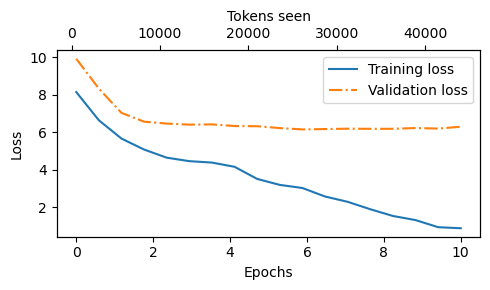

In [68]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


In [79]:
trainer = GPTTrainer(GPT_CONFIG_124M)
start_text = "Every effort moves you"

token_ids = trainer.generate(
    start_text=start_text,
    max_new_tokens=10
)

print("Generated text:\n", token_ids)

Generated text:
 Every effort moves you misproject';features nights pulledPC Viol millionsalam
